# COSC 325 Final Project: Credit Card Fraud Analysis
### By "Regularly Scheduled Programming"
**Will Greenwood**&emsp;**Maddie Gross**&emsp;**Cinzia Pacione**&emsp;**Ethan Weathers**

### Contents

- **Introduction and Getting Started**
    - Import Dependencies
    - Read and Clean Data
<p>&nbsp;</p>

- **Exploratory Data Analysis**
    - Subsections (not final yet)
<p>&nbsp;</p>

- **Machine Learning Analysis**
    - Random Forest Implementation
<p>&nbsp;</p>

## Introduction and Getting Started

Intro to this section...

### Import Dependencies

In [ ]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats

from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

### Read and Clean Data

Add details later...

In [18]:
# Store csv in a pandas DataFrame
df = pd.read_csv("fraud_data.csv")

# Drop unused columns
drop_columns = []
if drop_columns:
    df.drop(columns=drop_columns, inplace=True)

# Verify there are no null values
null_count = df.isnull().sum()

# Convert selective columns to appropriate data types
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'],
                                             format='%d-%m-%Y %H:%M')
df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')

# Add useful columns
df['age'] = 2019 - df['dob'].dt.year

#######################################################################
# We might not want to scale data if extreme values matter. idk :(
#######################################################################
# Scale numberical values with StandardScaler
# scaler_columns = ['amt', 'city_pop']
# scaler = StandardScaler()
# df[scaler_columns] = scaler.fit_transform(df[scaler_columns])


Optional cell to write metadata to a file:

In [19]:
show_metadata = False
if show_metadata:
    with open("metadata.txt", "w") as f:
        from io import StringIO
        
        buffer = StringIO()
        df.info(buf=buffer)
        f.write("DataFrame Info:\n")
        f.write(buffer.getvalue())
        
        f.write("\n\nNumber of unique values per column:\n")
        f.write(df.nunique().to_string())
        
        f.write("\n\nNull values per column:\n")
        f.write(null_count.to_string())

And here are some useful additions/lookups...

In [165]:
# Lookup total number of transactions in entire dataset
total_transactions = len(df)

# Separate DataFrame for just the fraudulent transactions
df_fraud = df[df['is_fraud'] == 1]
fraud_count = len(df_fraud)

# Dictionary to replace snake_case labels with regular text
label_map = {
    'grocery_pos':    'Grocery Pos',
    'gas_transport':  'Gas Transport',
    'shopping_net':   'Shopping Net',
    'shopping_pos':   'Shopping Pos',
    'home':           'Home',
    'kids_pets':      'Kids Pets',
    'personal_care':  'Personal Care',
    'entertainment':  'Entertainment',
    'health_fitness': 'Health Fitness',
    'food_dining':    'Food Dining',
    'misc_pos':       'Misc Pos',
    'misc_net':       'Misc Net',
    'grocery_net':    'Grocery Net',
    'travel':         'Travel'
}

## Exploratory Data Analysis

Intro to this section...

(Will) Pie charts:

**Fraud Index (Percent of Fradulent Transactions) by State**

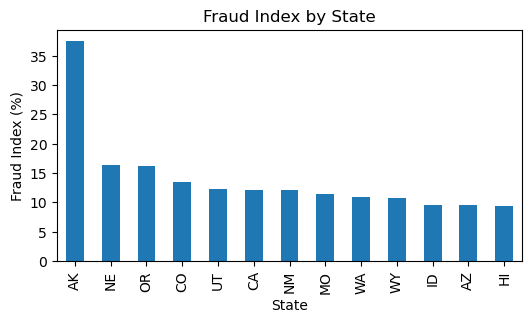

In [20]:
# States
# Step 1: Compute total transactions per state
total_state_tr = df['state'].value_counts()
fraud_state_tr = df[df['is_fraud'] == 1]['state'].value_counts()
fraud_index = (fraud_state_tr / total_state_tr) * 100

fraud_index.sort_values(ascending=False).plot(kind='bar', figsize=(6, 3))
plt.ylabel('Fraud Index (%)')
plt.xlabel('State')
plt.title('Fraud Index by State')
plt.show()


**Fraud by Age**

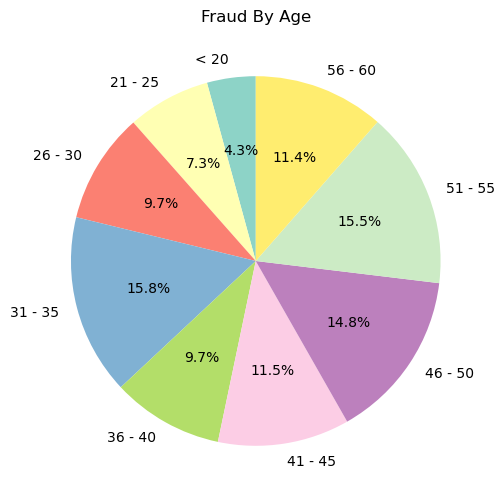

In [167]:
age_brackets = ['< 20',
                '21 - 25', '26 - 30',
                '31 - 35', '36 - 40',
                '41 - 45', '46 - 50',
                '51 - 55', '56 - 60']
age_ranges = [(0, 20),
              (21, 25), (26, 30),
              (31, 35), (36, 40),
              (41, 45), (46, 50),
              (51, 55), (56, 60)]

age_bracket_counts = {}
for bracket, (low, high) in zip(age_brackets, age_ranges):
    age_bracket_counts[bracket] = ((df_fraud['age'] >= low) & (df_fraud['age'] <= high)).sum()

age_fraud_percentage = {
    'Age Bracket': age_bracket_counts.keys(),
    'Percentage': [(count / fraud_count) * 100 for count in age_bracket_counts.values()]
}

age_percentage_df = pd.DataFrame(age_fraud_percentage)

# Plot pie chart
plt.figure(figsize=(8, 6))
age_percentage_df.set_index('Age Bracket')['Percentage'].plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Set3')
plt.ylabel('')
plt.title('Fraud By Age')
plt.show()

What does this tell us? Maybe ML model tageting age will not be useful since the distribution is pretty even.

**Fraud by Category**

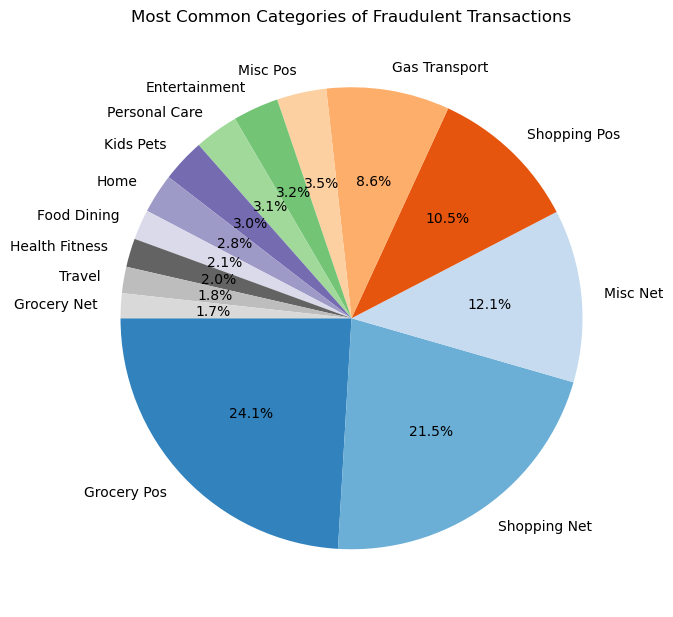

In [168]:
category_counts = df_fraud['category'].value_counts(normalize=True) * 100

# Apply mapping to rename labels
category_counts = category_counts.rename(index=label_map)

plt.figure(figsize=(10, 7.5))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=180, colormap='tab20c')
plt.ylabel('')  # Hide y-axis label
plt.title('Most Common Categories of Fraudulent Transactions')
plt.show()

These are more diverse results. Surely we can do something with this.

Histograms:

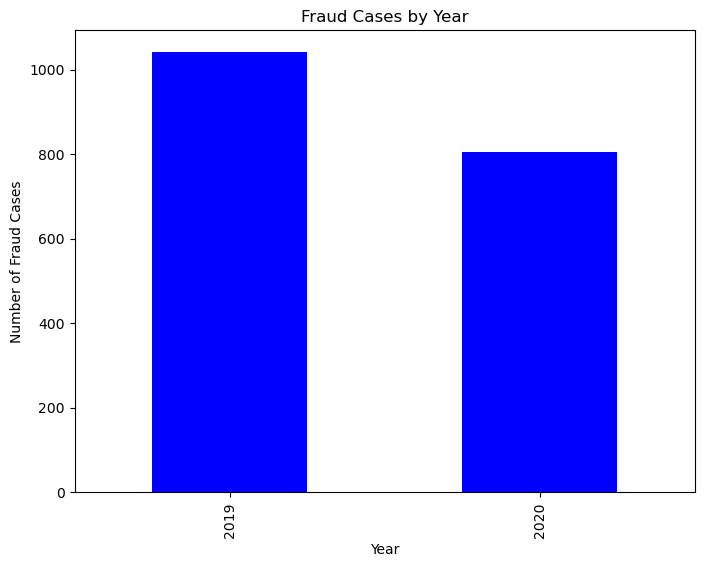

<function matplotlib.pyplot.show(close=None, block=None)>

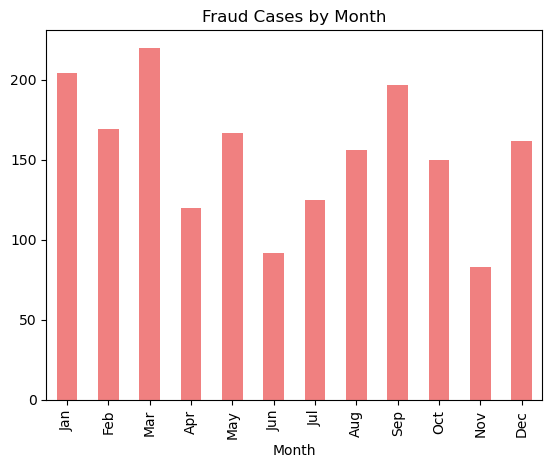

In [169]:
# Ethan
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year
fraud_df = df[df['is_fraud'] == 1]
fraud_by_month = fraud_df['month'].value_counts().sort_index()
fraud_by_year = fraud_df['year'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
fraud_by_year.plot(kind='bar', color='blue')
plt.title("Fraud Cases by Year")
plt.xlabel("Year")
plt.ylabel("Number of Fraud Cases")
plt.show()

fraud_by_month.plot(kind='bar', color='lightcoral')
plt.title("Fraud Cases by Month")
plt.xlabel("Month")
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show

Maps:

In [22]:
# Cinzia

Lists:

In [23]:
# Maddie

## Machine Learning

Intro to this section...

### Baseline Random Forest Implementation by *Robin Rawat*

Intro to this section...

blah blah...using [Rawat's random forest implementation](https://www.kaggle.com/code/robinsinghrawat/credit-card-fraud-analysis).

In [ ]:
# random forest baseline model

We will now expand upon Rawat's baseline model by tuning hyperparameters.

In [1]:
# hyperparameter tuning:
# n_estimators
# max_depth 
# criterion 


And finally, confusion matrix using optimal hyperparameters...

In [ ]:
# confusion matrix